In [1]:
%load_ext blackcellmagic

# VIRAL MYSTERY: COVID-19 CASES AMONG VACCINATED INDIVIDUALS IN SINGAPORE

Since the Covid-19 pandemic struck in 2020, the virus has confounded medical experts and policy makers alike at multiple turns. One of the biggest new mysteries to emerge in 2021 involves that of ["breakthrough infections"](https://www.npr.org/sections/health-shots/2021/04/13/986411423/a-mystery-under-study-how-why-and-when-covid-vaccines-arent-fully-protective) - people who had tested positive for Covid-19 despite being vaccinated.

No vaccine is 100% effective, so it's not a surprise that some vaccinated individuals would still test positive. But why and how these breakthrough infections occur remain something of a mystery thus far.

This notebook takes a look at 271 such breakthrough Covid-19 cases in Singapore, via publicly released data from the [Ministry of Health's website](https://www.moh.gov.sg/). I began tracking these cases in May 2021, and stopped on June 29 when the ministry decided to stop providing detailed data on each new case in Singapore. 

The 271 breakthrough cases in this dataset, the first of which was first publicly disclosed on [30th January 2021](https://www.moh.gov.sg/news-highlights/details/3-new-cases-of-locally-transmitted-covid-19-infection-30jan2021-update), is not a comprehensive tally by any means. For instance, I did not include a number of breakthrough cases among residents and staff at MINDSville@Napiri, a home for people with intellectual and developmental disabilities, as the ministry only released summary data on their vaccination status. No explanation was given as to why only a summary was provided for those cases. 

Corrections and revisions to the ministry's data aren't easy to track either, so there's no telling if had been more breakthrough cases than those tallied here. There are certainly more such cases from July onwards, when such data aren't publicly available anymore. 

This dataset is also missing key pieces of information - such as the medical condition of the breakthrough cases, and the treatment they received to cope with Covid-19, if any was required. There are 20 mentions of cases preliminarily linked to the B1617 Delta variant, but it is unclear whether the other 251 cases are unlinked to the Delta variant or if the information wasn't ready at the time of the press release's publication.

As we well know, having data and having answers are vastly different things. One doesn't always lead to the other, particularly for big questions like those surrounding breakthrough Covid-19 infections. Still, I hope this modest analysis would add a little bit to our understanding of the virus that has reshaped the way we live.

Final caveat: The number of breakthrough cases is very, very small compared to the number of people who have been vaccinated. As of [July 5](https://www.moh.gov.sg/news-highlights/details/update-on-local-covid-19-situation-(6-july-2021)), Singapore has fully vaccinated about 2.19 million people, while 1.48 million have received one dose.

The 196 fully vaccinated breakthrough cases in this dataset represent just 0.009% of those in Singapore who have received two shots of the Covid-19 vaccine. So the statistical context really matters here. But given what we've gone through with the pandemic, it would also be a mistake to dismiss these rare cases too casually. 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.offline as py
import seaborn as sns

mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 22})
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
py.init_notebook_mode(connected=False)
mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# LOAD DATA

Quick breakdown of the columns in this dataset. If you want to extract other details not in the columns shown here, such as occupation, check out the "Details" column.

### Reference Data 
* See columns 'Case_Number', 'Details', and 'URL'.


### Demographic Data
* See columns 'Age', 'Age Range', 'Gender', and 'Nationality'.


### Vaccination Data
* See columns 'Date_1st_Vac', 'Date_2nd_Vac', and 'Vac_Status'.
'Date_1st_Vac' and 'Date_2nd_Vac' refer respectively to the dates where an individual got his or her first and/or second vaccination shot. Their overall vaccination status ('Vac_Status') is indicated as "First Shot Only" or "Full Course". Singapore's official Covid-19 vaccination programme uses the Pfizer-BioNTech and Moderna mRNA vaccines, both of which entail a two-dose regime.


### Infection/Symptoms Data
* See columns 'Date_Confirmed', 'Date_Onset_Symptoms', 'Symptom_Status', and 'Cluster'
'Date_Confirmed' refers to the date that an individual officially tested positive for Covid-19, while 'Date_Onset_Symptoms' refers to the date when he or she first experienced symptoms linked to the virus. Those with no symptoms are classified as "Asymptomatic" in the "Symptoms_Status" column.
Note that the "Clusters" column is incomplete due to the information lag in contract tracing, ie, some cases aren't linked to a particular cluster at the point of announcement due to time needed for verification.

In [3]:
raw = pd.read_csv("../data/vac_271.csv")

In [4]:
raw.shape

(271, 14)

In [5]:
raw.head()

Case_Number  Age Age Range Gender Nationality Date_1st_Vac Date_2nd_Vac  \
0        63940   93     90-99      F   Singapore   2021-03-18   2021-04-09   
1        63975   85     80-89      M   Singapore   2021-03-11   2021-04-01   
2        64404   86     80-89      M   Singapore   2021-06-11          NaN   
3        60626   81     80-89      F   Singapore   2021-02-26          NaN   
4        62873   88     80-89      M   Singapore   2021-01-22   2021-02-15   

        Vac_Status Date_Confirmed Date_Onset_Symptoms        Symptom_Status  \
0      Full Course     2021-06-01        Asymptomatic          Asymptomatic   
1      Full Course     2021-06-01        Asymptomatic          Asymptomatic   
2  First Shot Only     2021-06-22          2021-06-22  Experienced Symptoms   
3  First Shot Only     2021-03-03          2021-02-27  Experienced Symptoms   
4      Full Course     2021-05-05          2021-05-04  Experienced Symptoms   

              Cluster                                            Details  \
0  Case 63887 cluster  a retiree. She is a family member and househol...   
1  Case 63973 cluster  a retiree. He is a family member and household...   
2  Case 64374 cluster  a retiree. He developed a sore throat on 22 Ju...   
3                 NaN  spouse of Case 60588[1], and a retiree. She de...   
4       Changi/#62873  employed by Ramky Cleantech Services Pte Ltd a...   

                                                 URL  
0  https://www.moh.gov.sg/news-highlights/details...  
1  https://www.moh.gov.sg/news-highlights/details...  
2  https://www.moh.gov.sg/news-highlights/details...  
3  https://www.moh.gov.sg/news-highlights/details...  
4  https://www.moh.gov.sg/news-highlights/details...

# 1. IS THE DELTA VARIANT TO BLAME?

Let's first deal with the main question on everyone's mind - how many of these "breakthrough cases" involve the B1617 Delta variant?

The data here is unfortunately patchy. There are only 20 mentions of the Delta or B1617 variant in the case notes, and the health ministry indicated that these 20 people only "tested preliminarily positive" for this particular variant. Results of the confirmatory tests have not been publicly released, to the best of my knowledge. 

And then there's the classic question:  Is "absence of evidence" of B1617 infection evidence of its absence for the other 92.6% of breakthrough cases? Again, we don't know if further tests were conducted and what the results might be.

But if we take publicly available data at face value - subject to the caveats above, then just about 7.4% of breakthrough cases in this dataset preliminarily involve the Delta variant.

In [6]:
# The health ministry's notes are inconsistent in their references to the Delta variant
# On some days, it could be "B1617", other times it could be "B.1617" or "B.1.617"
# Using "variant" as the keyword worked best in catching all the inconsistent references

delta = raw[raw["Details"].str.contains("variant")]

In [7]:
# just 20 cases with mentions of "variant" in their case notes

delta.shape

(20, 14)

In [8]:
#delta.to_csv("../data/delta.csv", index=False)

In [9]:
delta["Details"].values

array(['a retiree, and a family member and household contact of Case 64342. She developed a cough and fatigue on 18 June but did not seek medical attention. She was detected when she was tested for COVID-19 on 19 June as part of our community surveillance testing for visitors to 115 and 116 Bukit Merah View. On the same day, she was placed on quarantine as she had been identified as a family member and household contact of Case 64342, and reported her symptoms. Her test result came back positive for COVID-19 infection on 19 June. She has tested preliminarily positive for the Delta variant, and is pending further confirmatory tests. Her serology test result is pending. Case 64346 received her first dose of COVID-19 vaccine on 28 April, and the second dose on 26 May.',
       'employed by Ramky Cleantech Services Pte Ltd as a cleaner at Changi Airport Terminal 3. He developed a runny nose on 6 May but did not seek medical treatment. As he had been identified as a close contact of Case 62

# 2. DEMOGRAPHIC BREAKDOWN

It's an open question as to whether demographic or environmental/occupational factors play a bigger role in Covid-19 infection among breakthrough cases. 

For instance, Singapore has seen a considerable number of fully vaccinated cleaners, some of them elderly, test positive for Covid-19. Were they vlunerable on account of their age or working environment? This is something only a full medical study can tell.

The other thing to note is that Singapore started vaccinating its elderly population first, as well as frontline workers with higher risk of exposure to the virus. A different demographic profile of the breakthrough cases might emerge once more of the general population is vaccinated. 

For now, the key demographic takeaways for breakthrough cases are:

* 62% are men.


* 149, or 55% of the 271 breakthrough cases, are aged 50 and above.


* 52.6% of the 167 male breakthrough cases are aged 50 and above, while 58.7% of the 104 female breakthrough cases are aged 50 and above.


* The median age is 52. The youngest breakthrough case is 12, while the oldest is 93. There is no significant gap between the median age for male and female breakthrough cases - 51 and 53 respectively.


## 2.1 BY AGE/AGE-RANGE

In [10]:
print("Oldest breakthrough case: ", raw["Age"].max())

print("Youngest breakthrough case: ", raw["Age"].min())

print("Average age of breakthrough cases: ", raw["Age"].mean())

print("Median age of breakthrough cases: ", raw["Age"].median())

Oldest breakthrough case:  93
Youngest breakthrough case:  12
Average age of breakthrough cases:  51.5830258302583
Median age of breakthrough cases:  52.0


In [11]:
raw["Age Range"].value_counts()

50-59    55
60-69    49
40-49    47
30-39    46
70-79    31
20-29    25
80-89    13
10-19     4
90-99     1
Name: Age Range, dtype: int64

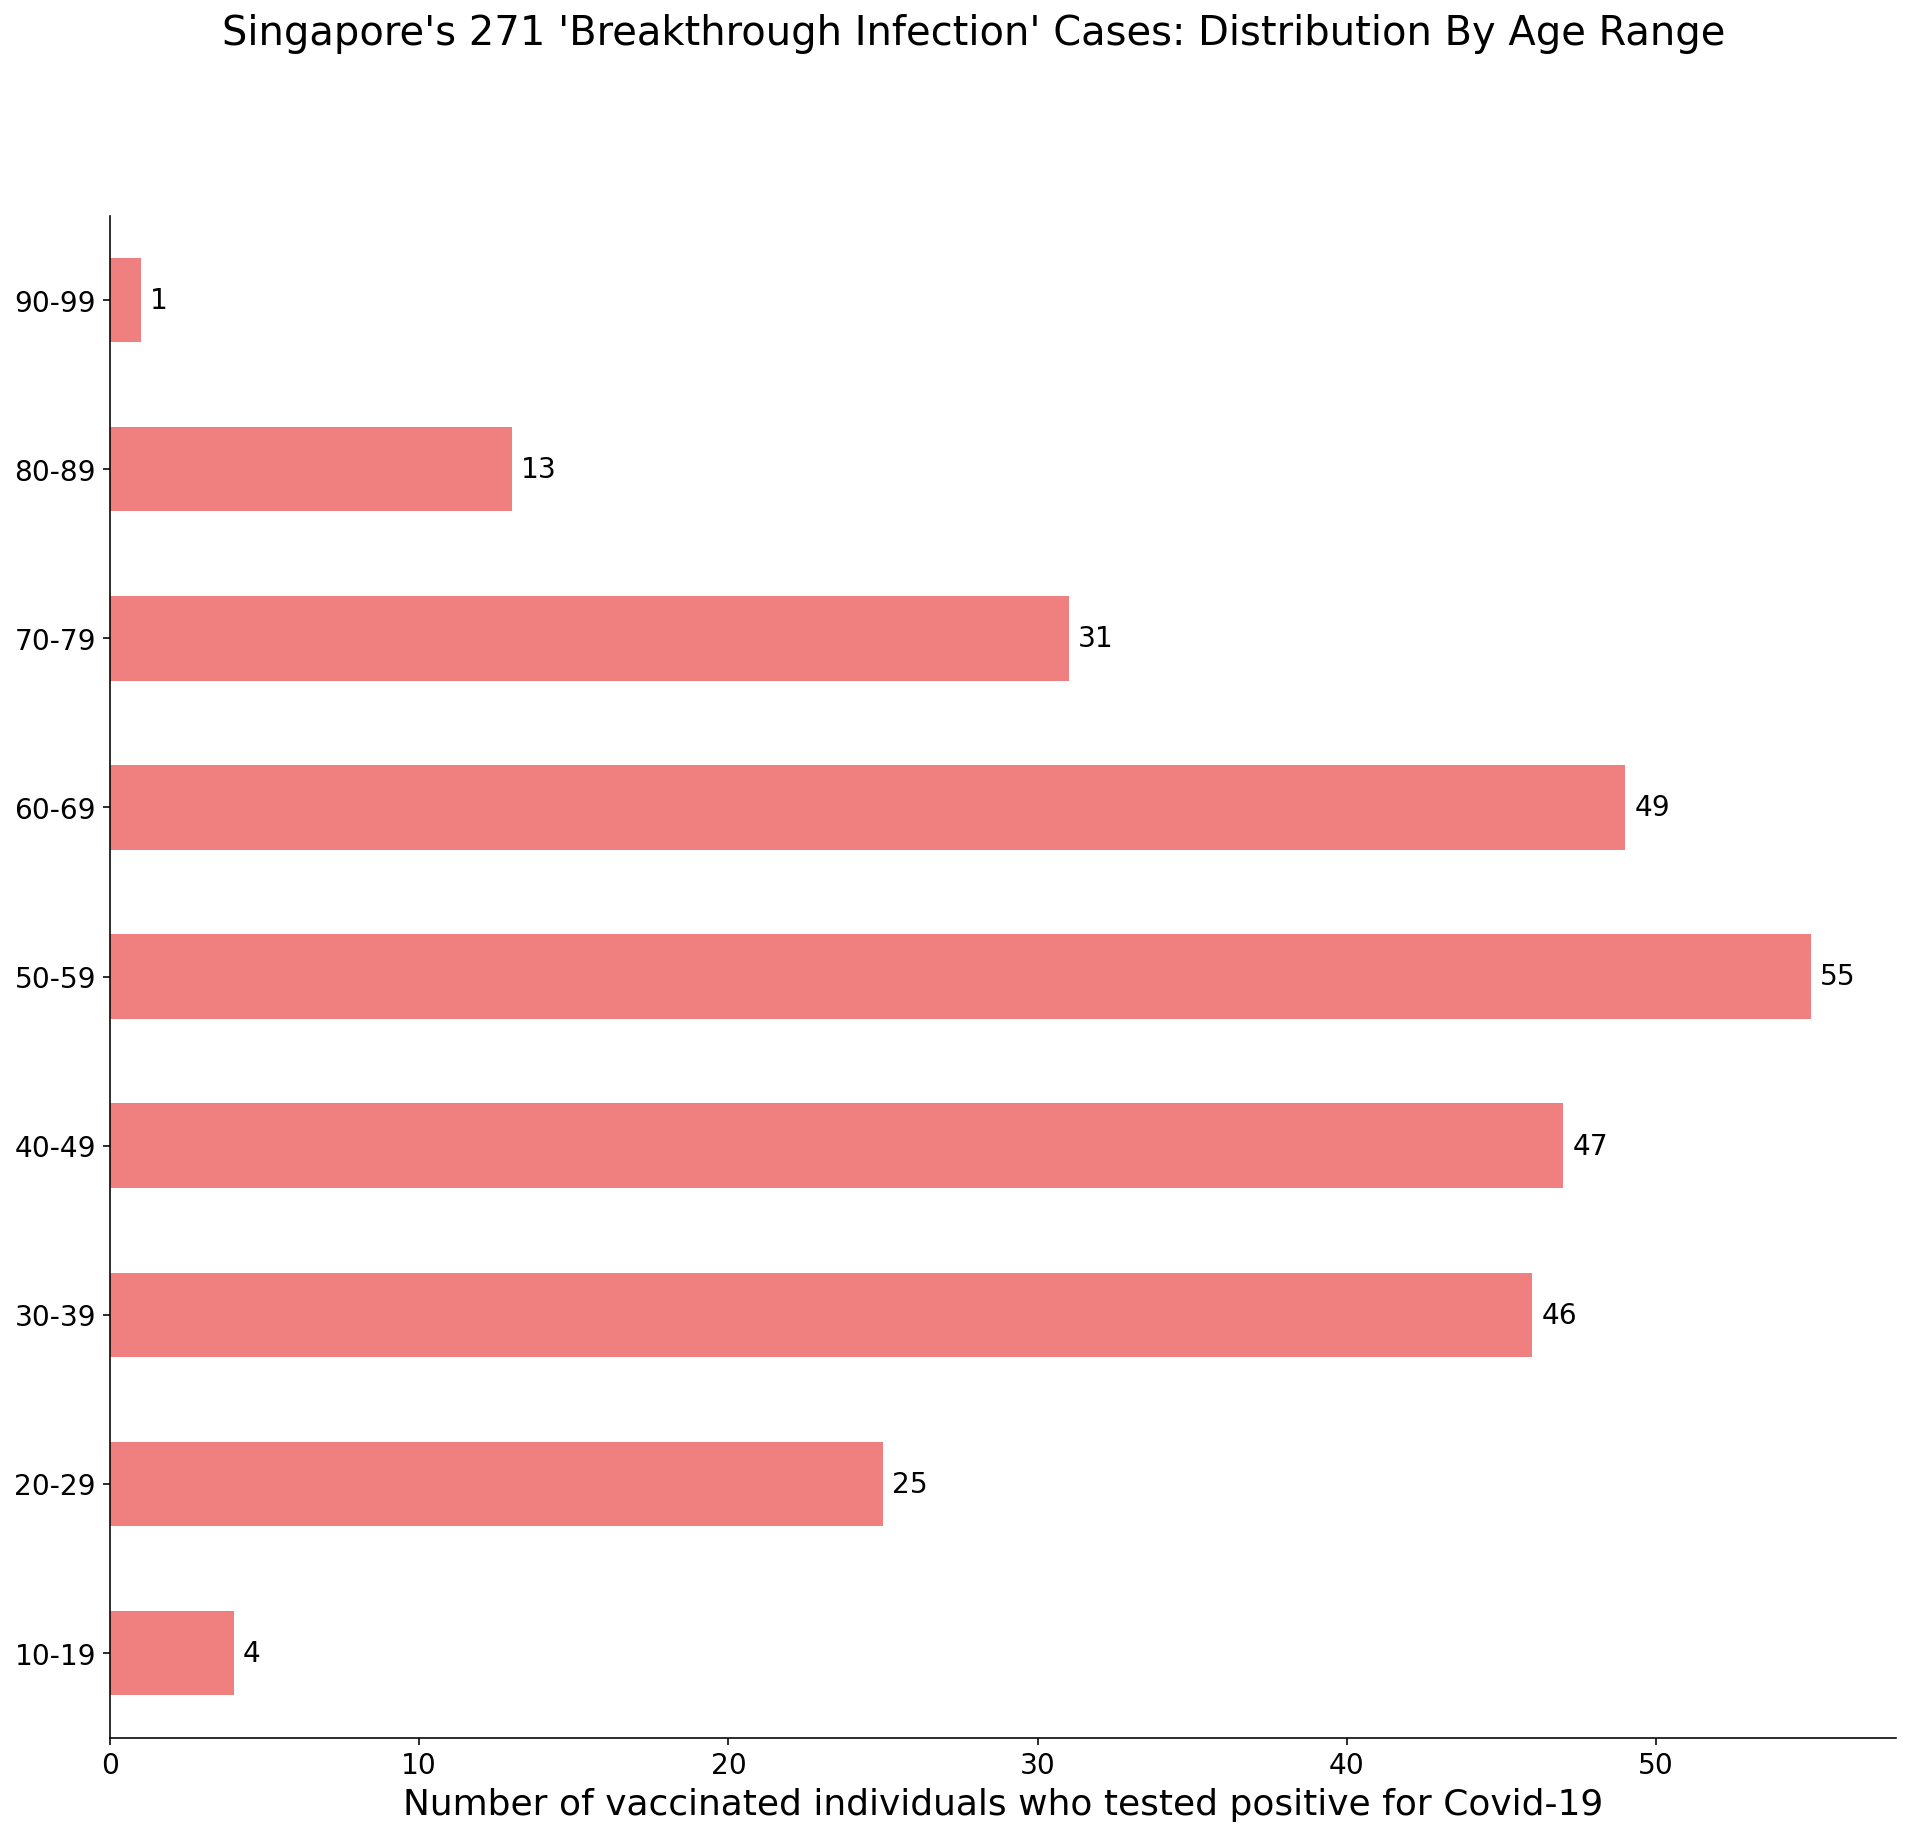

In [12]:
age = raw.sort_values(by="Age Range", ascending=False)

fig, ax = plt.subplots(figsize=(16, 14))

age["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="lightcoral"
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

fig.suptitle(
    "Singapore's 271 'Breakthrough Infection' Cases: Distribution By Age Range", fontsize=20
)

plt.ylabel("", fontsize=18)
plt.xlabel("Number of vaccinated individuals who tested positive for Covid-19", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## NOTE:
Due to the extremes between the oldest and youngest breakthrough cases, it would be better to reference the median age of 52, though this doesn't differ that much from the average age of 51.6.

149, or 55% of the 271 breakthrough cases, are aged 50 and above.

But at this point, one can't fully conclude that older people are more prone to "breakthrough infections". Singapore vaccinated older residents first, as they are generally more vulnerable to Covid-19, before rolling out the vaccines to younger residents.

A different picture could emerge as more younger people are vaccinated.

## 2.2 BY GENDER

* Men account for 62% of the breakthrough cases. The median age for male and female breakthrough cases is similar - 51 and 53 respectively.

In [13]:
raw["Gender"].value_counts()

M    167
F    104
Name: Gender, dtype: int64

## 2.2 BY GENDER AND AGE/AGE-RANGE

* 52.6% of the 167 male breakthrough cases are aged 50 and above, while 58.7% of the 104 female breakthrough cases are aged 50 and above.

* Easier to see this with a side-by-side chart, so let's plot it out below.

In [14]:
raw.groupby(["Gender"])["Age Range"].value_counts()

Gender  Age Range
F       50-59        24
        40-49        18
        60-69        18
        30-39        14
        70-79        12
        20-29         9
        80-89         6
        10-19         2
        90-99         1
M       30-39        32
        50-59        31
        60-69        31
        40-49        29
        70-79        19
        20-29        16
        80-89         7
        10-19         2
Name: Age Range, dtype: int64

In [15]:
men = raw[raw["Gender"]=="M"]
women = raw[raw["Gender"]=="F"]

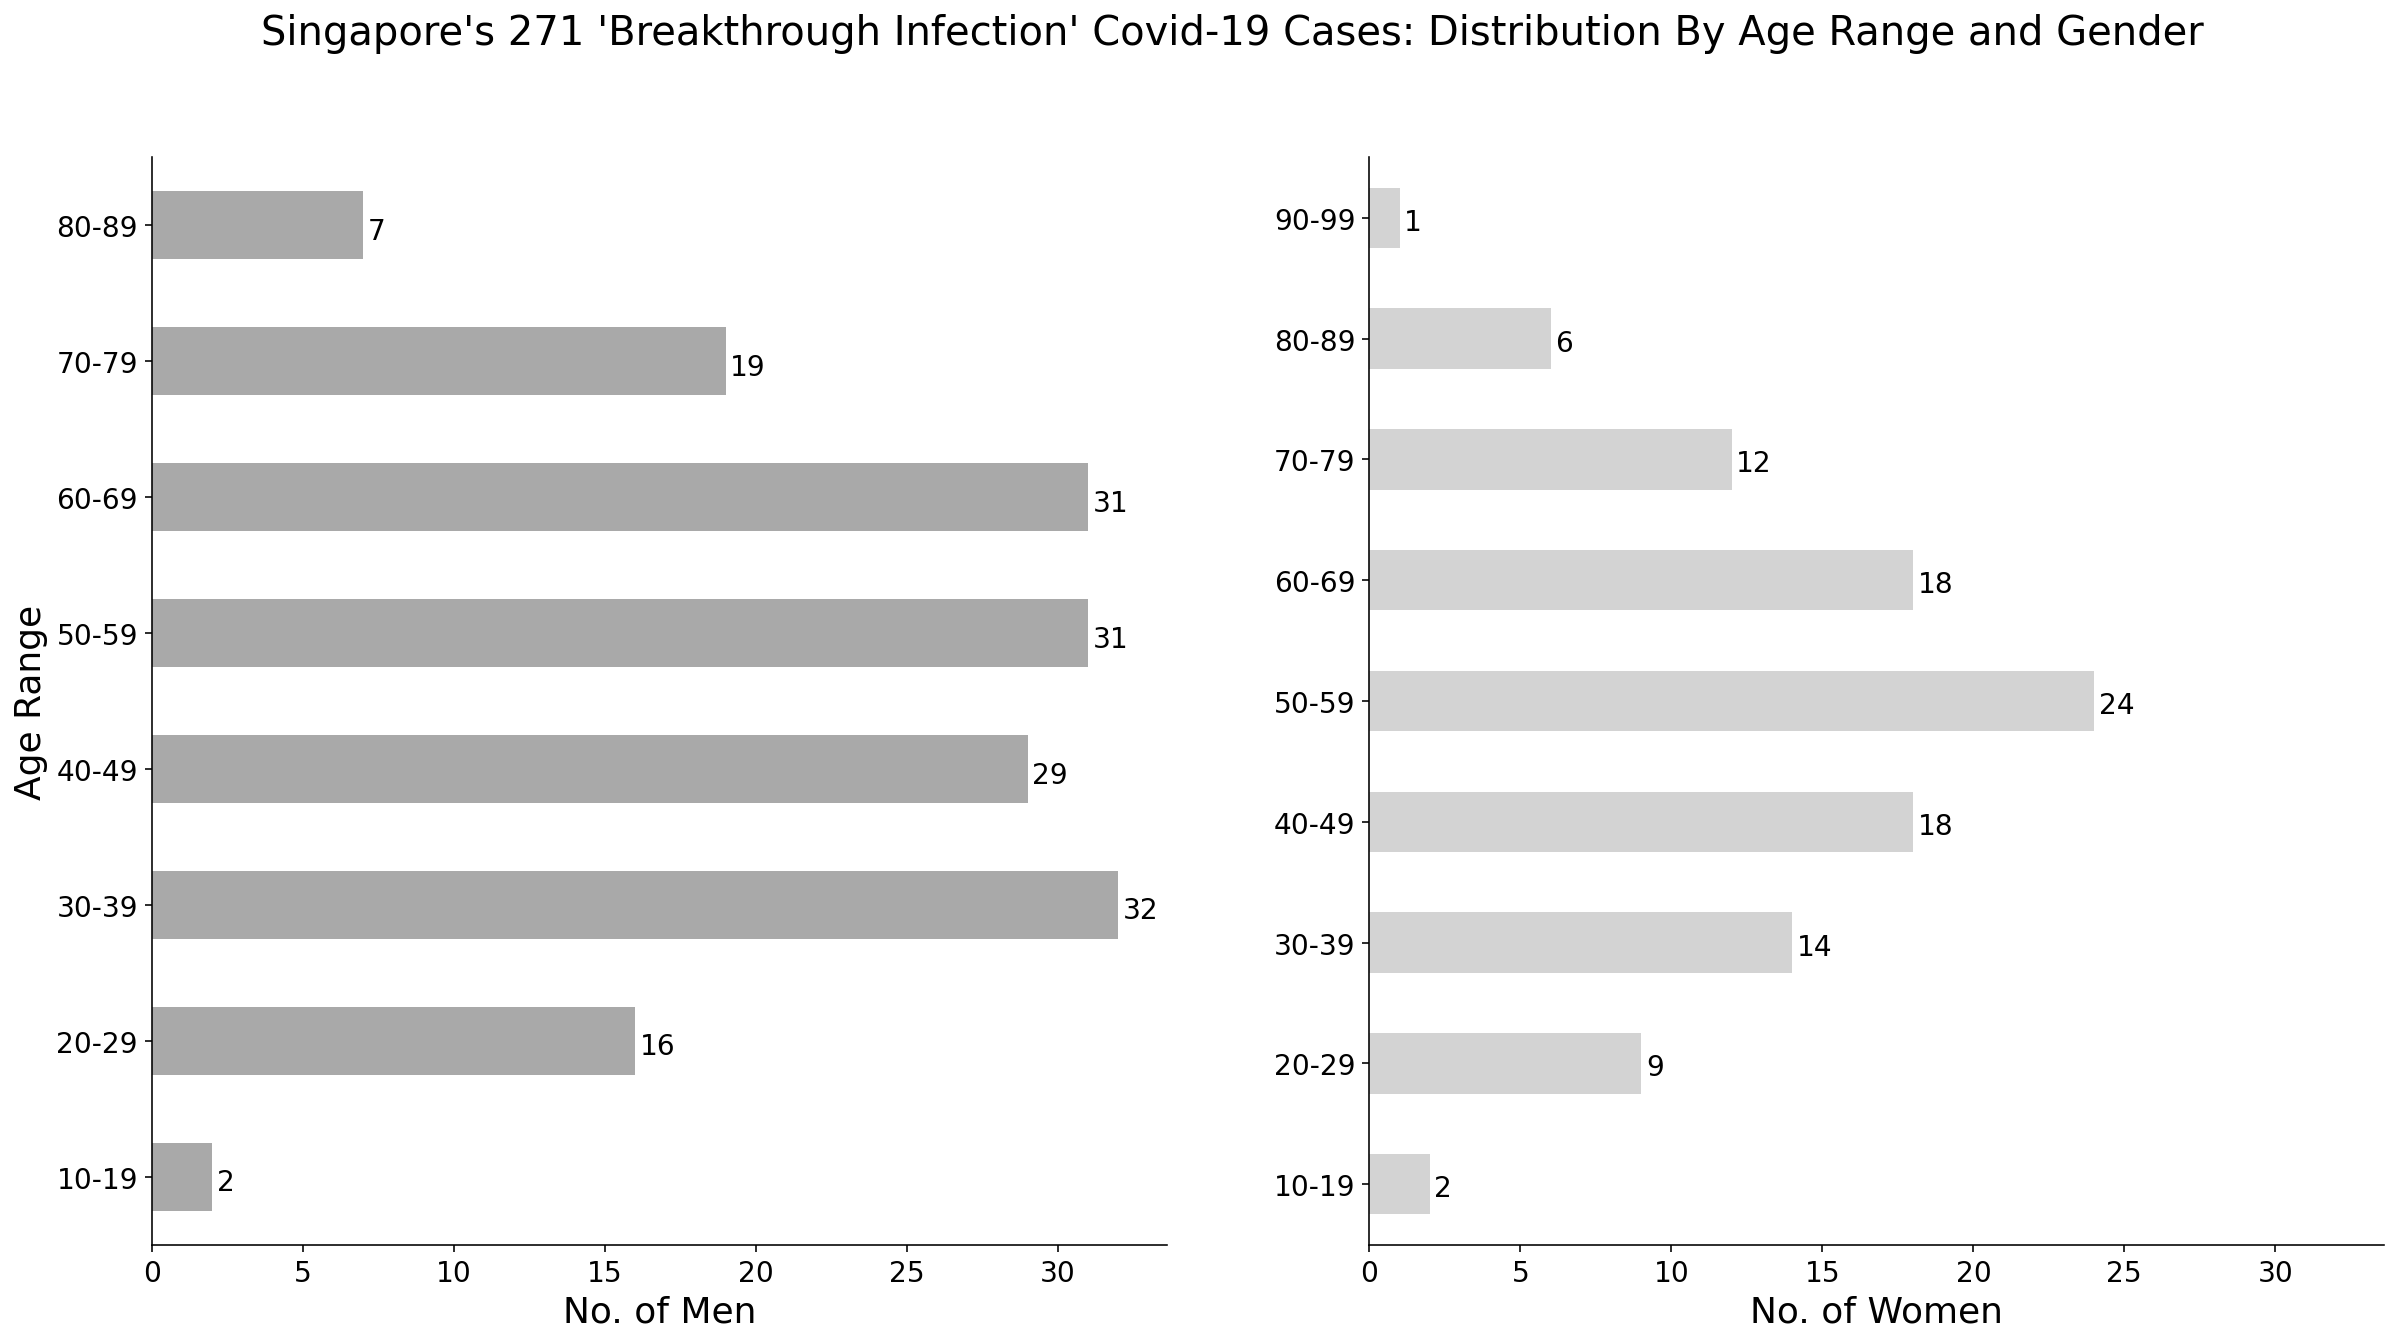

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

men["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="darkgrey", ax=axs[0]
)

women["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="lightgrey", ax=axs[1]
)

totals1 = []

# find the values and append to list
for i in axs[0].patches:
    totals1.append(i.get_width())

# set individual bar lables using above list
total1 = sum(totals1)

# set individual bar lables using above list
for i in axs[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[0].text(
        i.get_width() + 0.15,
        i.get_y() + 0.15,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

    
totals2 = []

# find the values and append to list
for j in axs[1].patches:
    totals2.append(j.get_width())

# set individual bar lables using above list
total2 = sum(totals2)

# set individual bar lables using above list
for j in axs[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[1].text(
        j.get_width() + 0.15,
        j.get_y() + 0.15,
        str(round((j.get_width()))),
        fontsize=14,
        color="black",
    )    
    
        
    
fig.suptitle(
    "Singapore's 271 'Breakthrough Infection' Covid-19 Cases: Distribution By Age Range and Gender", fontsize=20
)

axs[0].set_ylabel("Age Range", fontsize=18)
axs[1].set_ylabel("", fontsize=18)
axs[0].set_xlabel("No. of Men", fontsize=18)
axs[1].set_xlabel("No. of Women", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

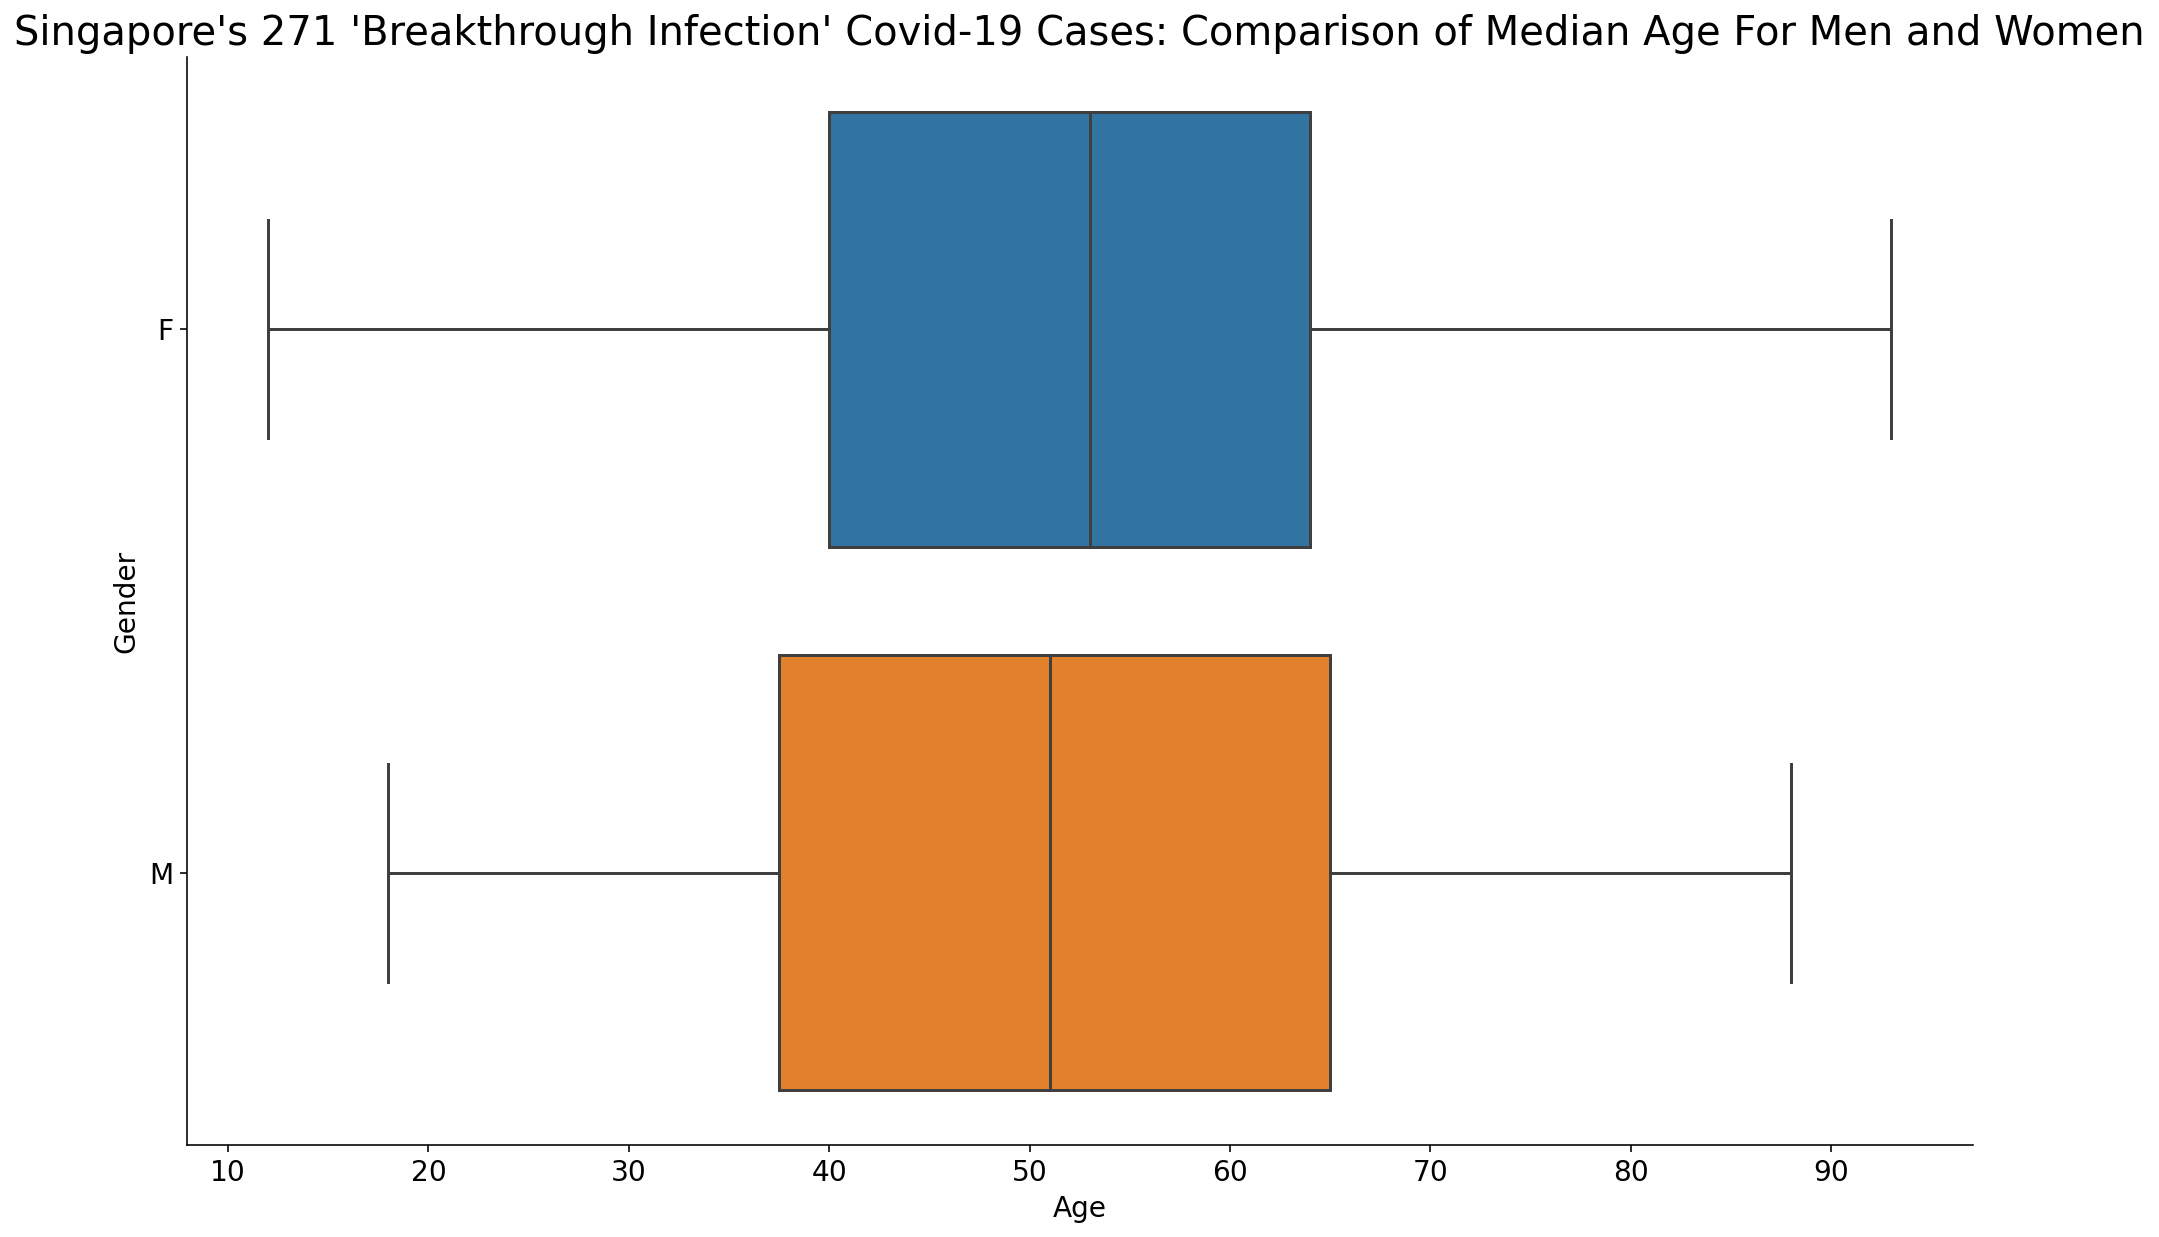

In [17]:
# I also wanted to compare the median age for male and female breakthrough cases to see if there's any significant difference
# Doesn't seem to be the case

plt.figure(figsize=(16, 10))
sns.boxplot(
    x="Age",
    y="Gender",
    data=raw,
)
plt.title(
    "Singapore's 271 'Breakthrough Infection' Covid-19 Cases: Comparison of Median Age For Men and Women",
    fontsize=20,
)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Gender", fontsize=14)
plt.grid(False)
sns.despine()
plt.show()

In [18]:
# Median age of breakthrough cases by gender don't seem that different
men["Age"].median(), women["Age"].median()

(51.0, 53.0)

# 3. VACCINATION STATUS BREAKDOWN

* About 7-in-10 of the 271 breakthrough cases were fully vaccinated. The breakdown by vaccination status and age range threw up an interesting detail: 47 of the 75 people (~63%) who had only one shot of the vaccine are in the age range of 40-59. But it is unclear whether they got infected while waiting for their second shot, or if they missed their second shot and hence got a lower level of protection.

* Singapore has been adjusting its [vaccination strategy](https://www.gov.sg/article/update-on-covid-19-vaccination-programme-and-guidance-on-the-use-of-masks) in response to the Delta variant, so the profile of breakthrough cases here could be quite different from countries where the vaccination programmes are more mature, such as Israel.

In [19]:
# 72.3% of the 271 cases were fully vaccinated

raw["Vac_Status"].value_counts()

Full Course        196
First Shot Only     75
Name: Vac_Status, dtype: int64

## 3.1 BREAKDOWN BY VACCINATION STATUS AND GENDER

In [20]:
raw.groupby(["Gender"])["Vac_Status"].value_counts()

Gender  Vac_Status     
F       Full Course         70
        First Shot Only     34
M       Full Course        126
        First Shot Only     41
Name: Vac_Status, dtype: int64

## 3.2 BREAKDOWN BY VACCINATION STATUS AND AGE RANGE

In [21]:
raw.groupby(["Age Range"])["Vac_Status"].value_counts()

Age Range  Vac_Status     
10-19      First Shot Only     3
           Full Course         1
20-29      Full Course        22
           First Shot Only     3
30-39      Full Course        39
           First Shot Only     7
40-49      Full Course        24
           First Shot Only    23
50-59      Full Course        31
           First Shot Only    24
60-69      Full Course        45
           First Shot Only     4
70-79      Full Course        24
           First Shot Only     7
80-89      Full Course         9
           First Shot Only     4
90-99      Full Course         1
Name: Vac_Status, dtype: int64

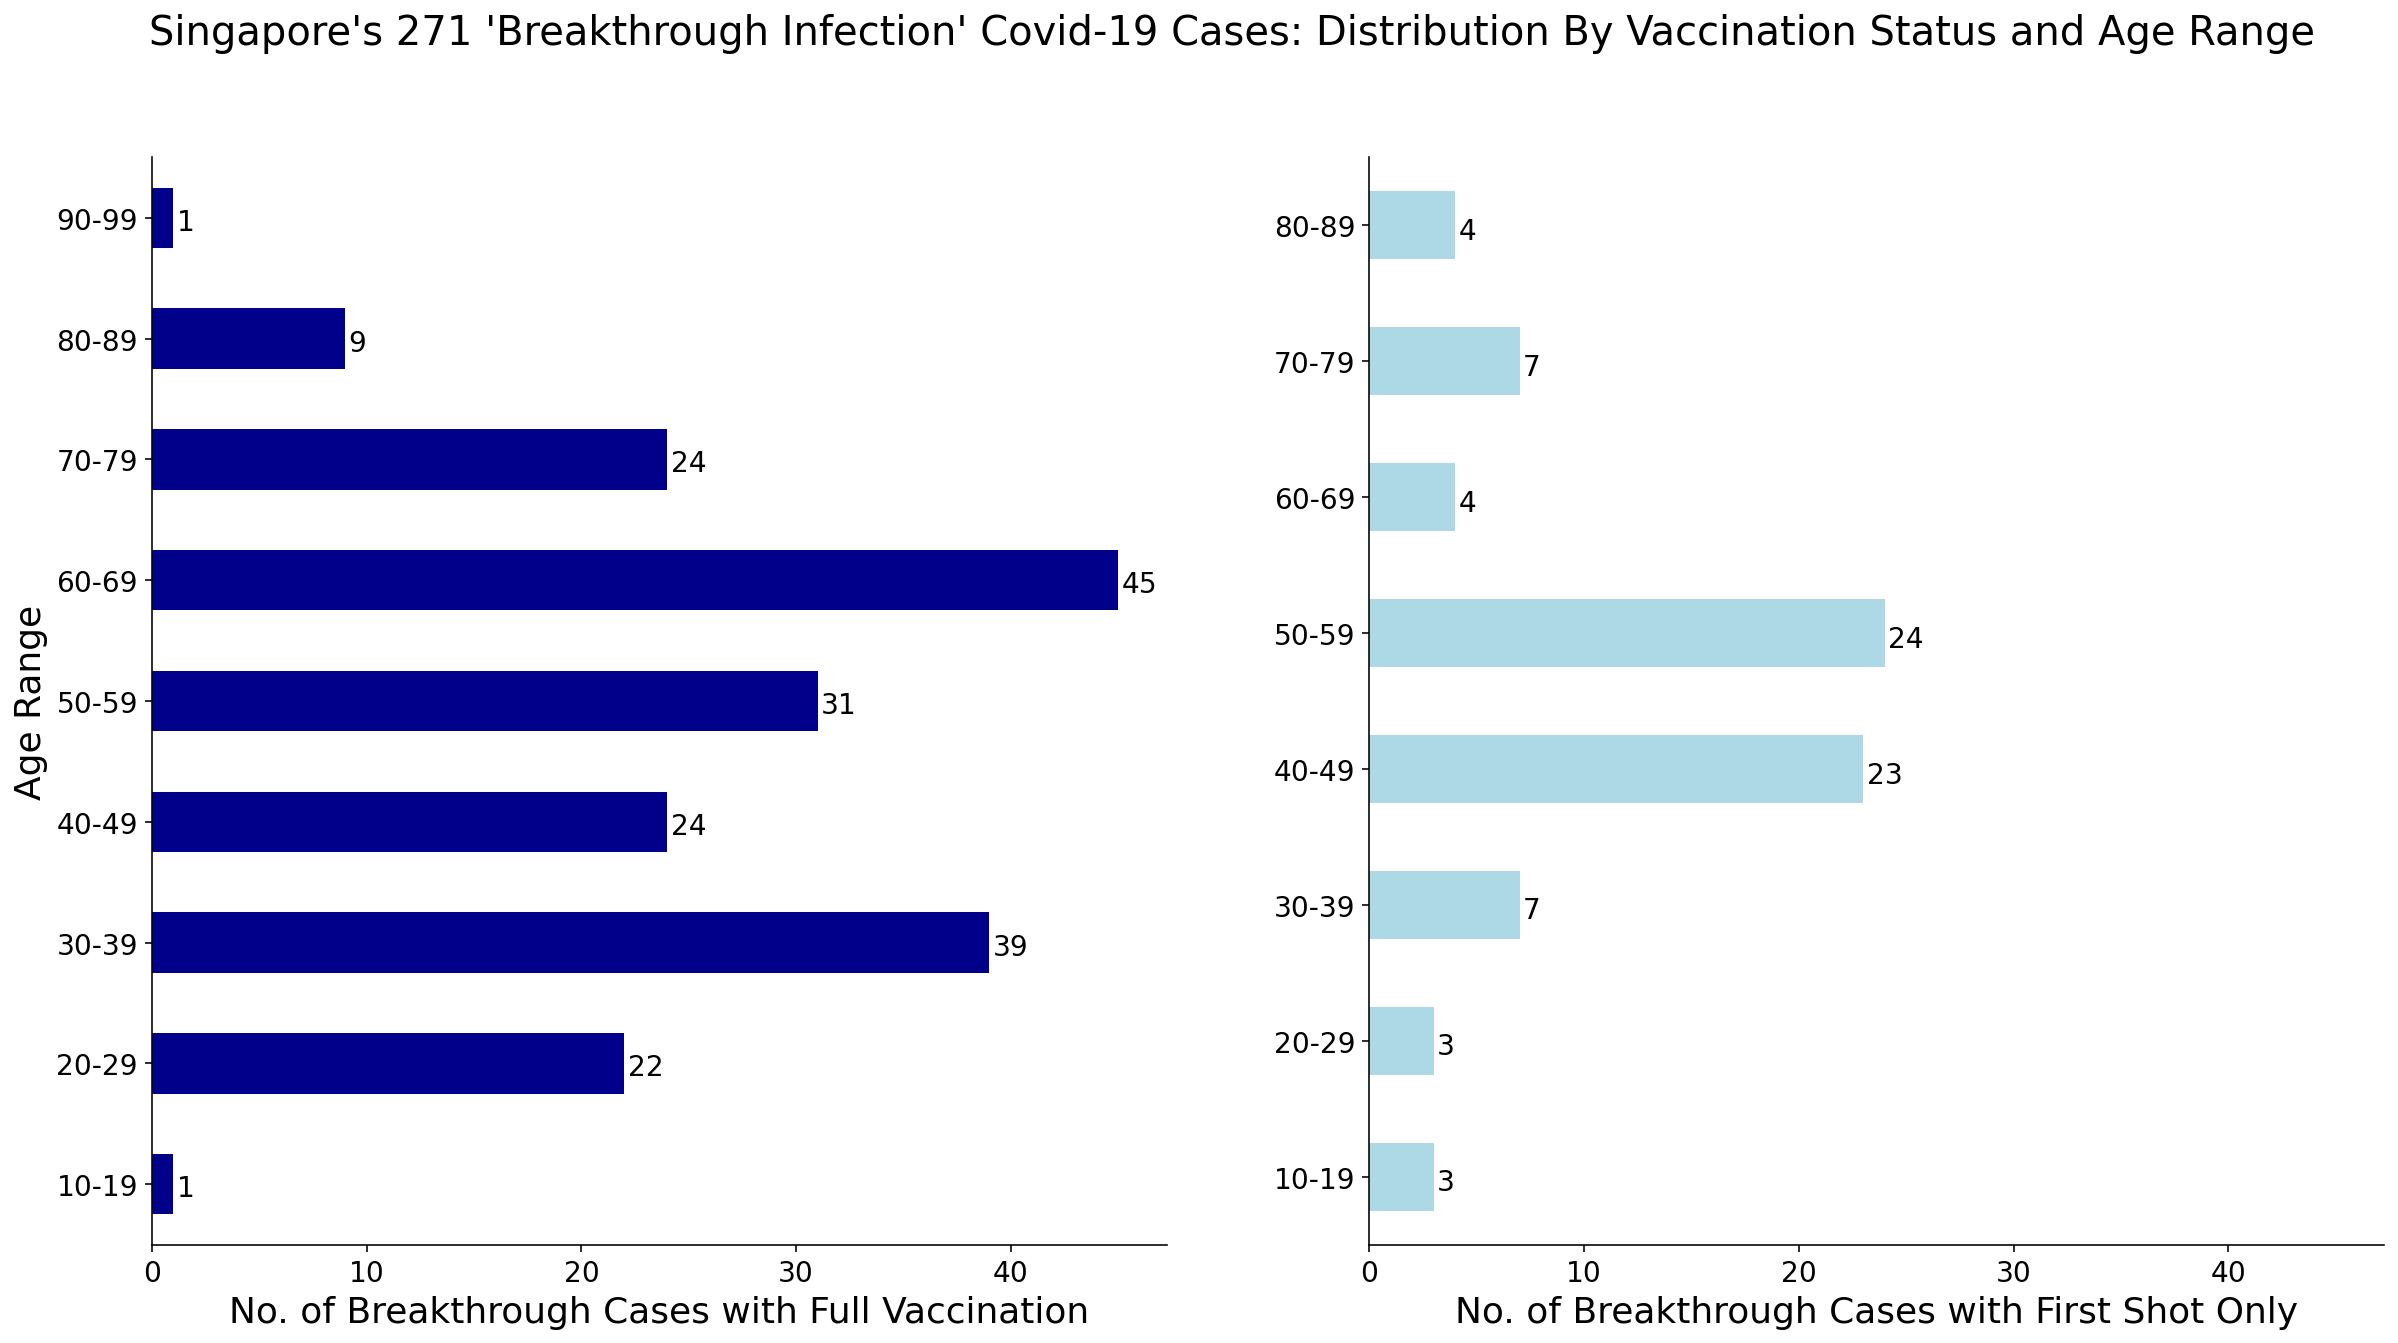

In [22]:
full = raw[raw["Vac_Status"]=="Full Course"]
single = raw[raw["Vac_Status"]=="First Shot Only"]

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

full["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="darkblue", ax=axs[0]
)

single["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="lightblue", ax=axs[1]
)

totals1 = []

# find the values and append to list
for i in axs[0].patches:
    totals1.append(i.get_width())

# set individual bar lables using above list
total1 = sum(totals1)

# set individual bar lables using above list
for i in axs[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[0].text(
        i.get_width() + 0.15,
        i.get_y() + 0.15,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

    
totals2 = []

# find the values and append to list
for j in axs[1].patches:
    totals2.append(j.get_width())

# set individual bar lables using above list
total2 = sum(totals2)

# set individual bar lables using above list
for j in axs[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[1].text(
        j.get_width() + 0.15,
        j.get_y() + 0.15,
        str(round((j.get_width()))),
        fontsize=14,
        color="black",
    )    
    
            
fig.suptitle(
    "Singapore's 271 'Breakthrough Infection' Covid-19 Cases: Distribution By Vaccination Status and Age Range", fontsize=20
)

axs[0].set_ylabel("Age Range", fontsize=18)
axs[1].set_ylabel("", fontsize=18)
axs[0].set_xlabel("No. of Breakthrough Cases with Full Vaccination", fontsize=18)
axs[1].set_xlabel("No. of Breakthrough Cases with First Shot Only", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

As the Singapore government vaccinated the older population first, it is no surprise that we see more breakthrough cases among the older age groups. It would be interesting to see how this changes, if at all, as younger people are vaccinated in larger numbers.  

# 4. SYMPTOMS STATUS BREAKDOWN

## 4.1 BY SYMPTOMS STATUS AND GENDER

About 1-in-3 of the 271 breakthrough cases are asymptomatic. Of those who are asymptomatic, no big difference among men and women in this dataset, ie, 35% of men were asymptomatic while ~32% of women were asymptomatic.

In [23]:
# 34%, or about 1-in-3 of the 271 breakthrough cases, are asymptomatic

raw["Symptom_Status"].value_counts()

Experienced Symptoms    179
Asymptomatic             92
Name: Symptom_Status, dtype: int64

In [24]:
raw.groupby("Gender")["Symptom_Status"].value_counts()

Gender  Symptom_Status      
F       Experienced Symptoms     71
        Asymptomatic             33
M       Experienced Symptoms    108
        Asymptomatic             59
Name: Symptom_Status, dtype: int64

## 4.2 BY SYMPTOMS STATUS AND AGE RANGE

In [25]:
raw.groupby("Age Range")["Symptom_Status"].value_counts()

Age Range  Symptom_Status      
10-19      Asymptomatic             2
           Experienced Symptoms     2
20-29      Experienced Symptoms    16
           Asymptomatic             9
30-39      Experienced Symptoms    25
           Asymptomatic            21
40-49      Experienced Symptoms    35
           Asymptomatic            12
50-59      Experienced Symptoms    38
           Asymptomatic            17
60-69      Experienced Symptoms    33
           Asymptomatic            16
70-79      Experienced Symptoms    22
           Asymptomatic             9
80-89      Experienced Symptoms     8
           Asymptomatic             5
90-99      Asymptomatic             1
Name: Symptom_Status, dtype: int64

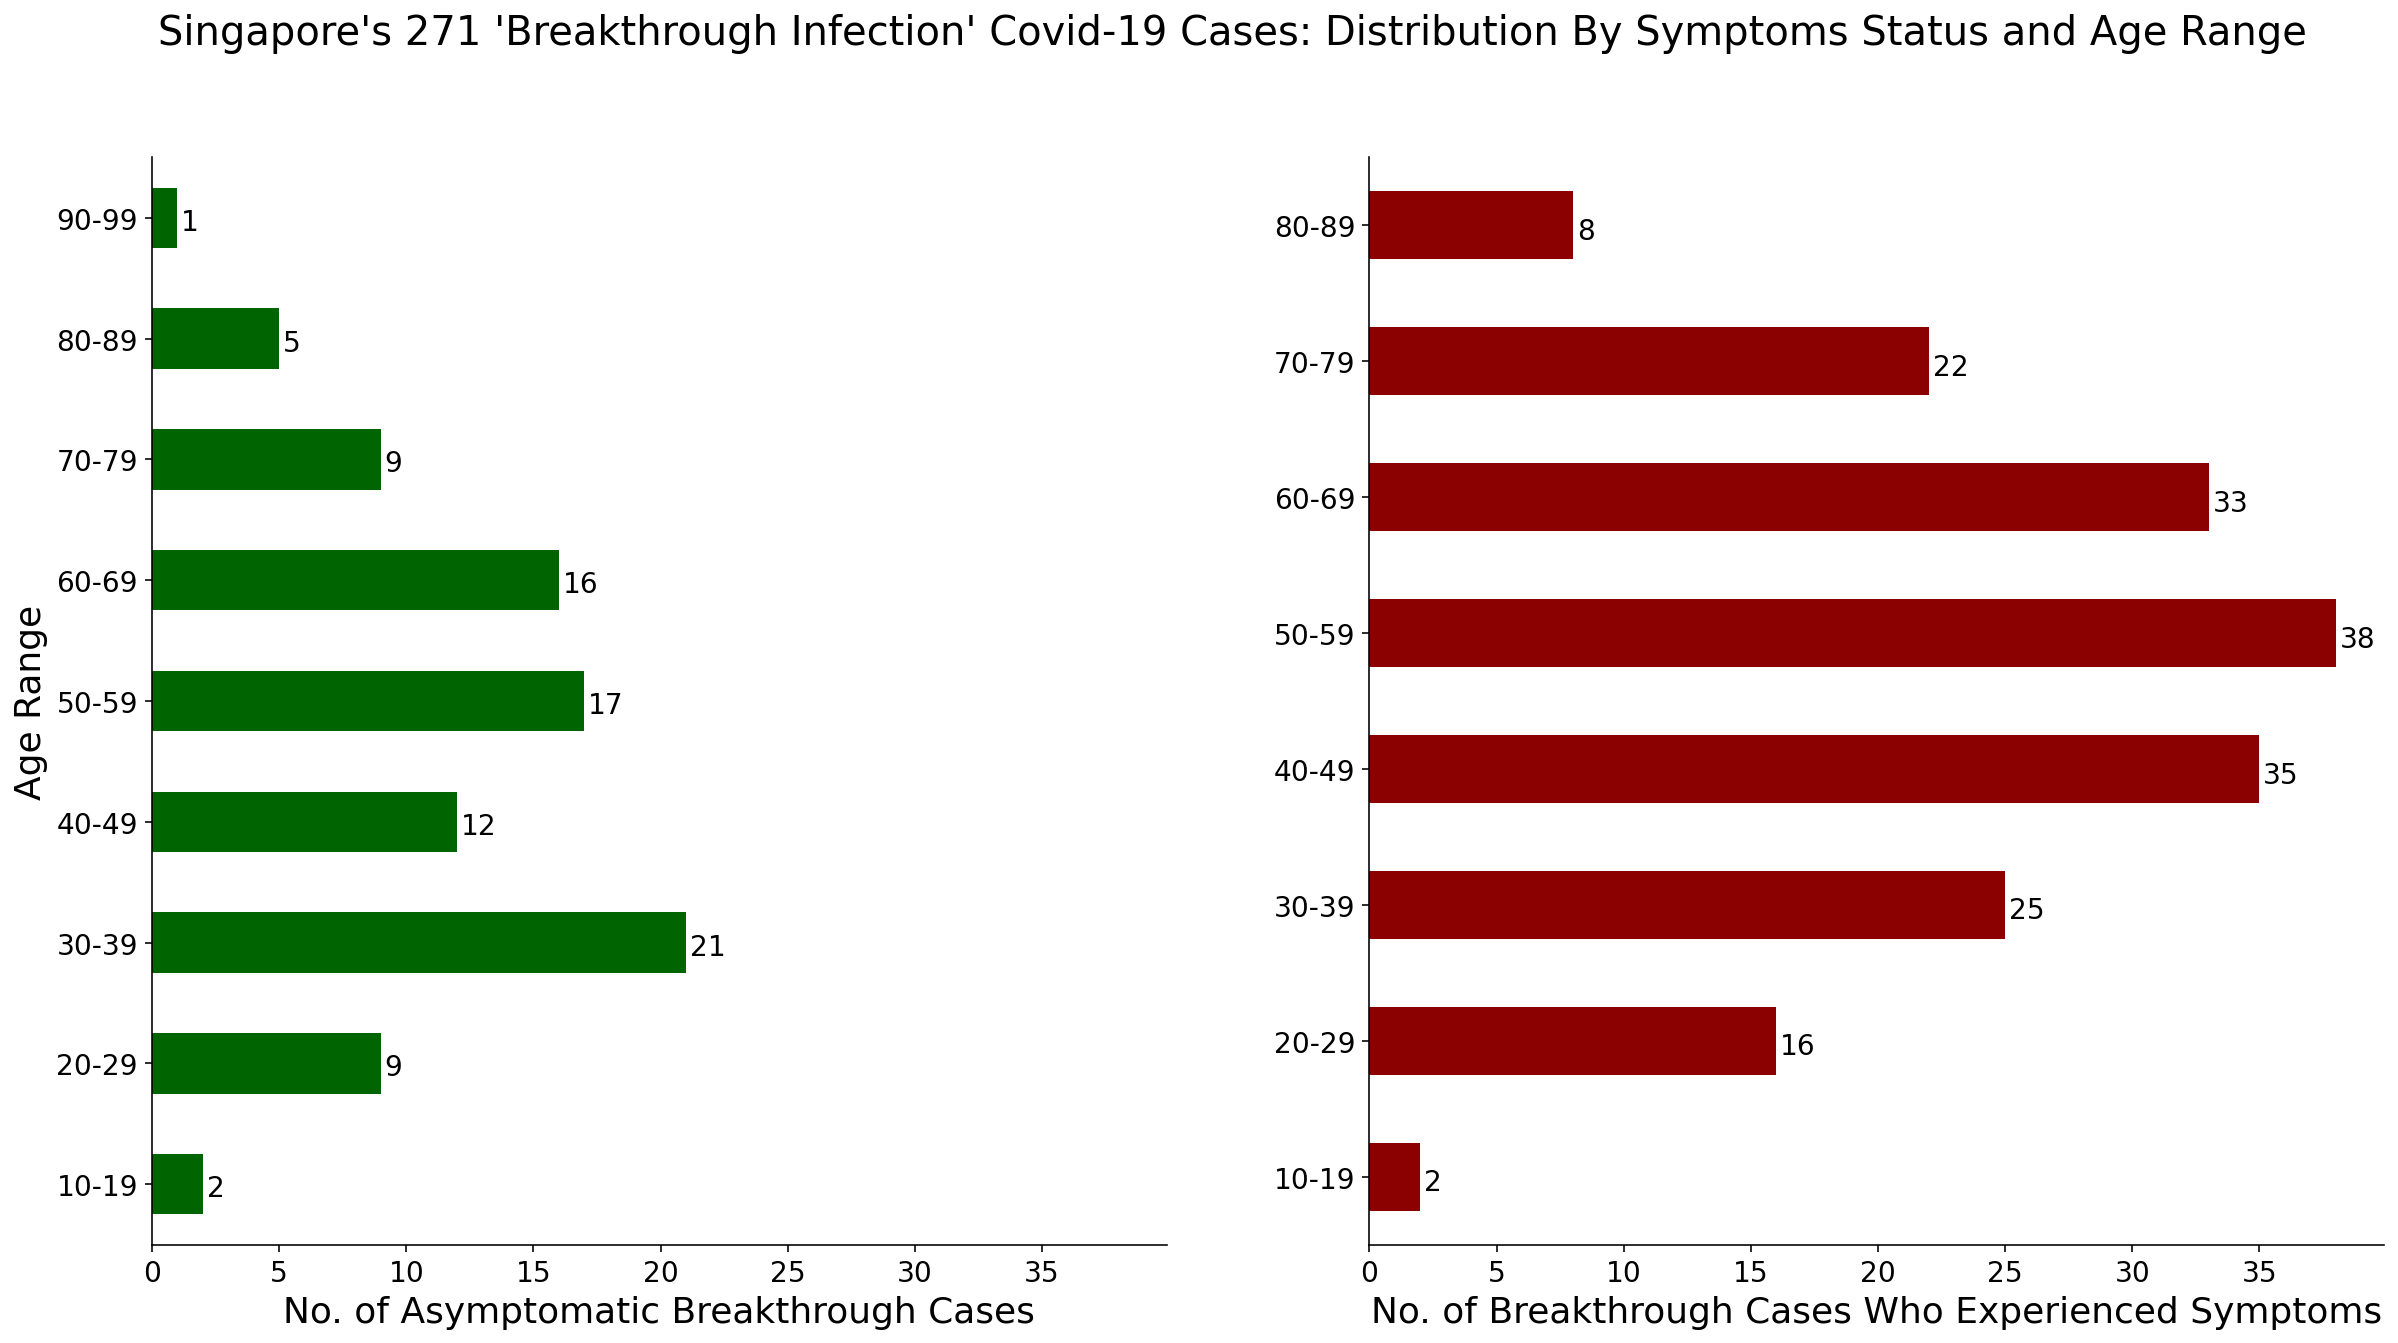

In [26]:
asymptomatic = raw[raw["Symptom_Status"]=="Asymptomatic"]
symptoms = raw[raw["Symptom_Status"]=="Experienced Symptoms"]

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

asymptomatic["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="darkgreen", ax=axs[0]
)

symptoms["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="darkred", ax=axs[1]
)

totals1 = []

# find the values and append to list
for i in axs[0].patches:
    totals1.append(i.get_width())

# set individual bar lables using above list
total1 = sum(totals1)

# set individual bar lables using above list
for i in axs[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[0].text(
        i.get_width() + 0.15,
        i.get_y() + 0.15,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

    
totals2 = []

# find the values and append to list
for j in axs[1].patches:
    totals2.append(j.get_width())

# set individual bar lables using above list
total2 = sum(totals2)

# set individual bar lables using above list
for j in axs[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[1].text(
        j.get_width() + 0.15,
        j.get_y() + 0.15,
        str(round((j.get_width()))),
        fontsize=14,
        color="black",
    )    
    
            
fig.suptitle(
    "Singapore's 271 'Breakthrough Infection' Covid-19 Cases: Distribution By Symptoms Status and Age Range", fontsize=20
)

axs[0].set_ylabel("Age Range", fontsize=18)
axs[1].set_ylabel("", fontsize=18)
axs[0].set_xlabel("No. of Asymptomatic Breakthrough Cases", fontsize=18)
axs[1].set_xlabel("No. of Breakthrough Cases Who Experienced Symptoms", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## NOTE:



## 4.3 BY SYMPTOMS STATUS AND VACCINATION STATUS

In [27]:
raw.groupby("Vac_Status")["Symptom_Status"].value_counts()

Vac_Status       Symptom_Status      
First Shot Only  Experienced Symptoms     54
                 Asymptomatic             21
Full Course      Experienced Symptoms    125
                 Asymptomatic             71
Name: Symptom_Status, dtype: int64

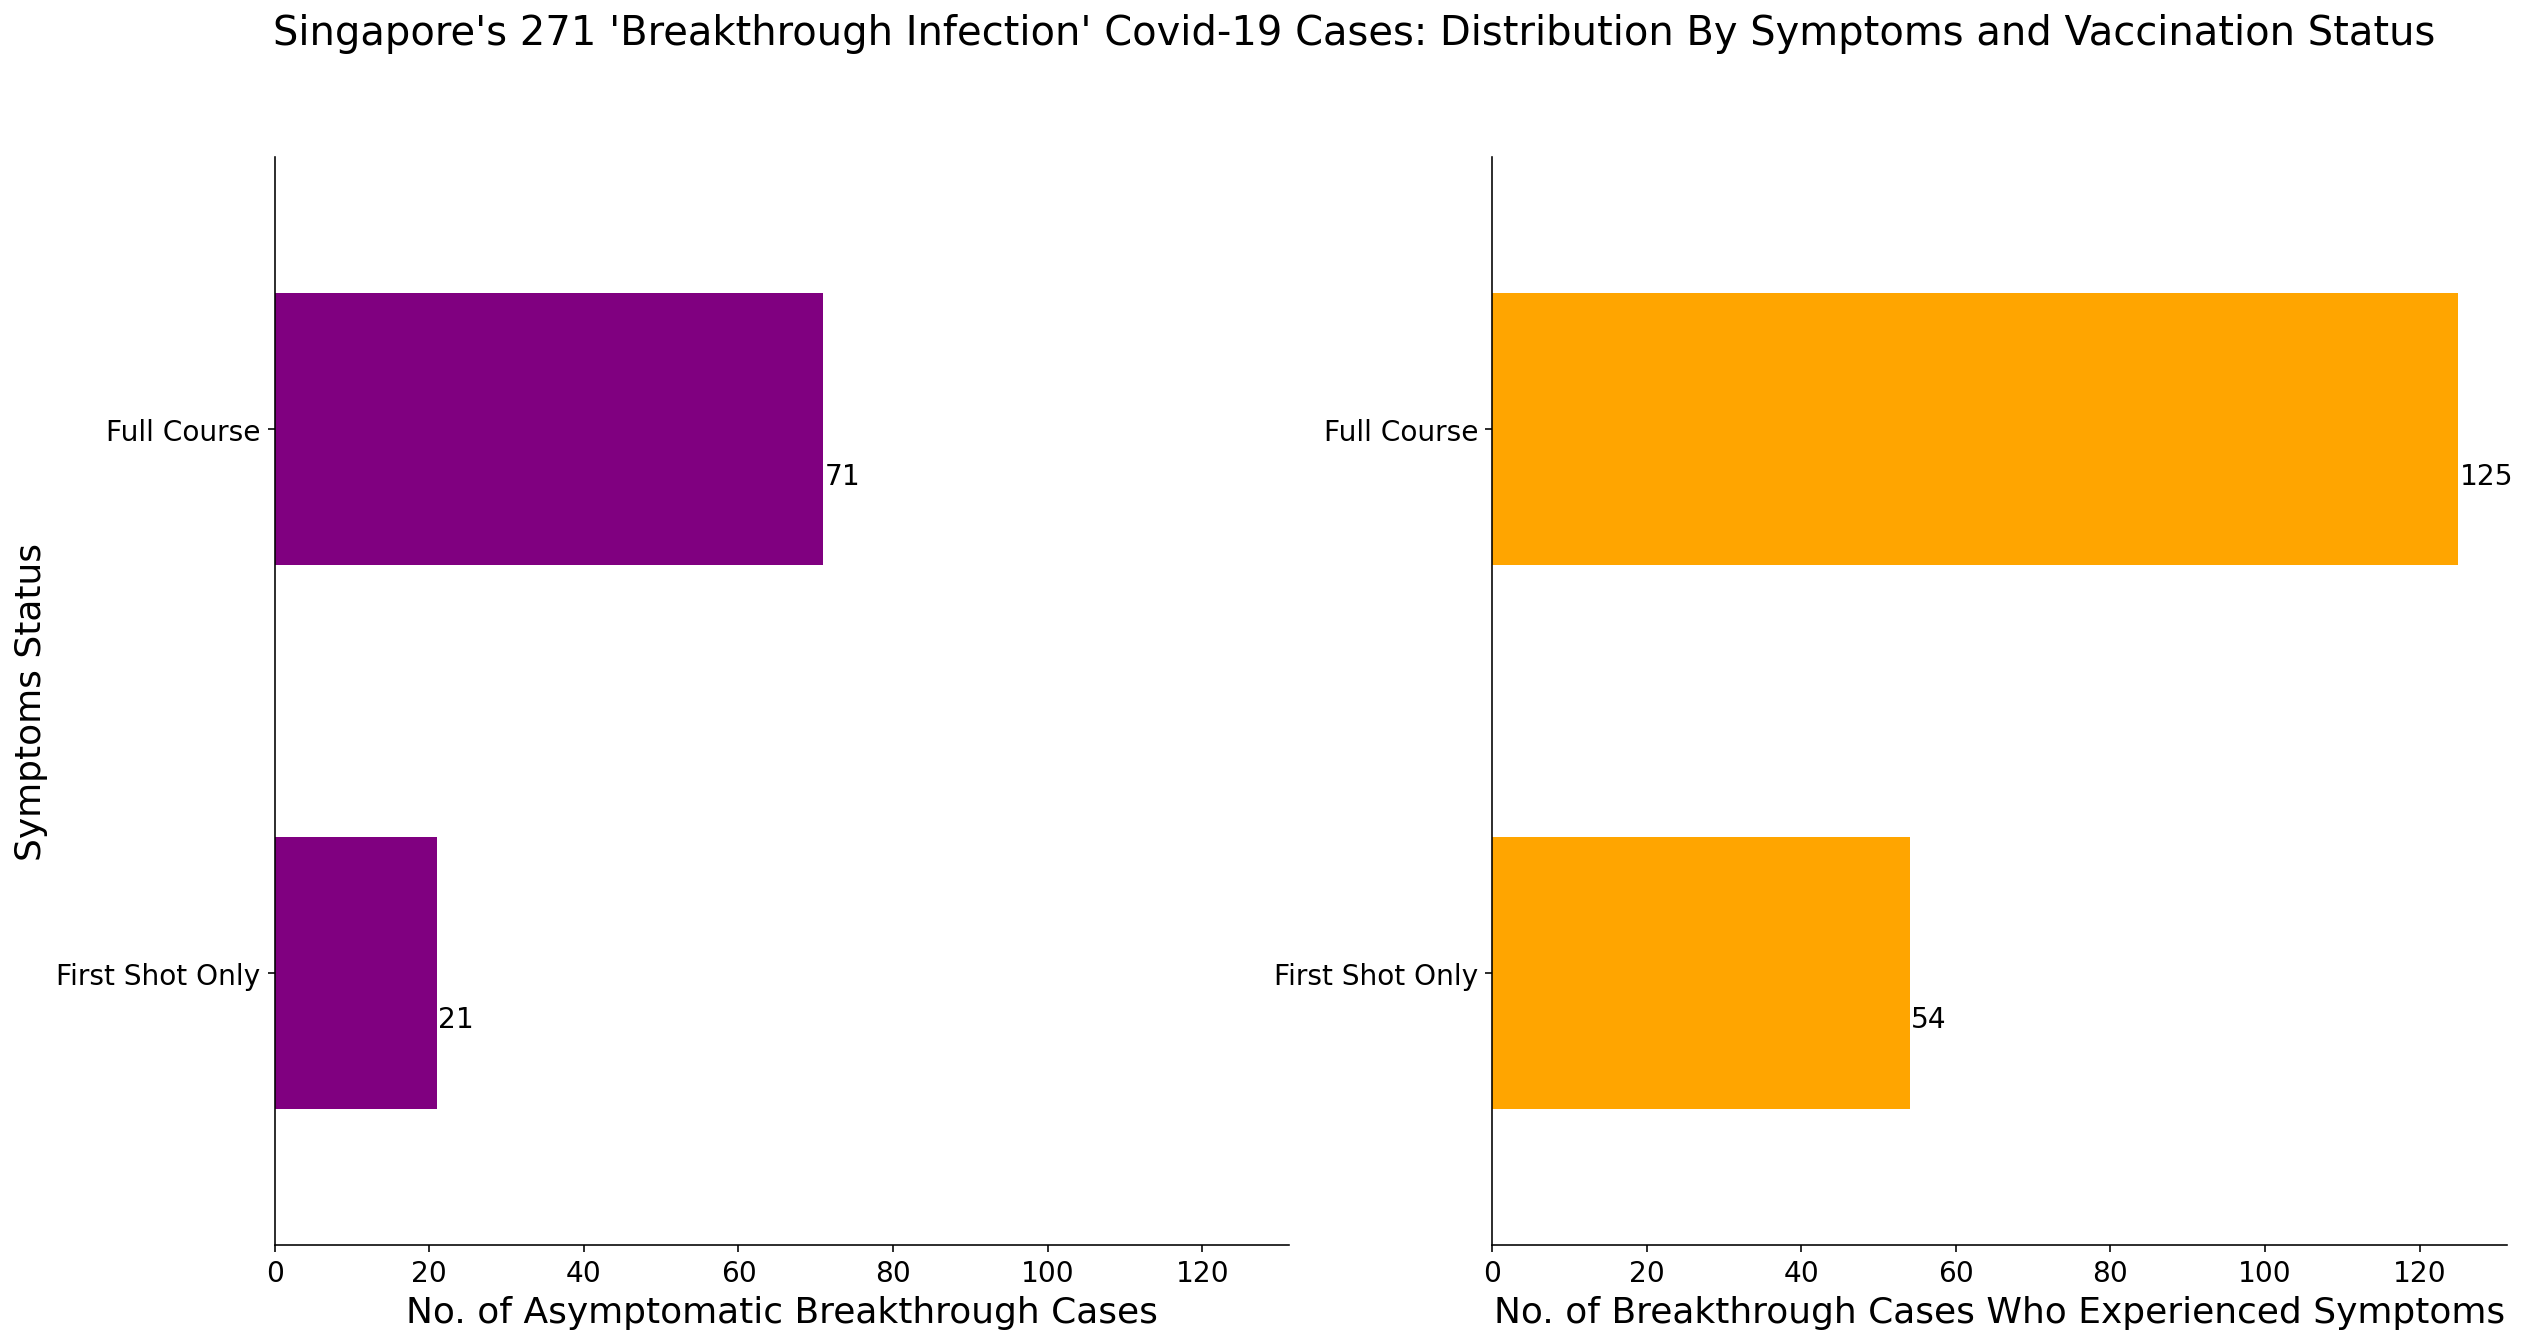

In [28]:
asymptomatic = raw[raw["Symptom_Status"]=="Asymptomatic"]
symptoms = raw[raw["Symptom_Status"]=="Experienced Symptoms"]

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

asymptomatic["Vac_Status"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="purple", ax=axs[0]
)

symptoms["Vac_Status"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="orange", ax=axs[1]
)

totals1 = []

# find the values and append to list
for i in axs[0].patches:
    totals1.append(i.get_width())

# set individual bar lables using above list
total1 = sum(totals1)

# set individual bar lables using above list
for i in axs[0].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[0].text(
        i.get_width() + 0.15,
        i.get_y() + 0.15,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

    
totals2 = []

# find the values and append to list
for j in axs[1].patches:
    totals2.append(j.get_width())

# set individual bar lables using above list
total2 = sum(totals2)

# set individual bar lables using above list
for j in axs[1].patches:
    # get_width pulls left or right; get_y pushes up or down
    axs[1].text(
        j.get_width() + 0.15,
        j.get_y() + 0.15,
        str(round((j.get_width()))),
        fontsize=14,
        color="black",
    )    
    
            
fig.suptitle(
    "Singapore's 271 'Breakthrough Infection' Covid-19 Cases: Distribution By Symptoms and Vaccination Status", fontsize=20
)

axs[0].set_ylabel("Symptoms Status", fontsize=18)
axs[1].set_ylabel("", fontsize=18)
axs[0].set_xlabel("No. of Asymptomatic Breakthrough Cases", fontsize=18)
axs[1].set_xlabel("No. of Breakthrough Cases Who Experienced Symptoms", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

# 5. NUMBER OF DAYS BETWEEN VACCINATION AND INFECTION

Experts have pointed out time and again that getting the full 2-shot regime confers better protection against Covid-19. This is borne out by the data here as well, when we compare the number of days between vaccination and infection for those who got the full course, and those who only got one shot.

For the 196 fully vaccinated cases, the median number of days between getting the second shot and confirmation of Covid-19 infection is 59 days. 

For the 75 breakthrough cases who only got one shot of the vaccine, the median number of days between getting the single shot and confirmation of Covid-19 infection is just 13 days.

The differences are clearer when you do a side-by-side comparison of Gantt charts for these two windows for individual cases. I'm not a medical or vaccine expert, so I won't weigh in on whether the 59 days between full vaccination and confirmation of Covid-19 infection for these breakthrough cases is something worrisome or not.

But if it isn't clear by now: Don't skip your second shot!

## 5.1 FULLY VACCINATED "BREAKTHROUGH CASES"

In [29]:
# Convert entries to pandas date-time format
full["1st_Vac"] = pd.to_datetime(full['Date_1st_Vac'], yearfirst=True).dt.date

full["2nd_Vac"] = pd.to_datetime(full['Date_2nd_Vac'], yearfirst=True).dt.date

full["Covid_Confirmed"] = pd.to_datetime(full['Date_Confirmed'], yearfirst=True).dt.date


# Calculate no. of days between fully vaccination and infection
full["Days Between Full Vaccination And Covid-19 Confirmation"] = (
    full["Covid_Confirmed"] - full["2nd_Vac"]
).dt.days

In [30]:
cols1 = [
    "Case_Number",
    "Date_2nd_Vac",
    "Date_Confirmed",
    "Days Between Full Vaccination And Covid-19 Confirmation",
]

full_vac = full[cols1]

In [31]:
full_vac.head()

Case_Number Date_2nd_Vac Date_Confirmed  \
0        63940   2021-04-09     2021-06-01   
1        63975   2021-04-01     2021-06-01   
4        62873   2021-02-15     2021-05-05   
5        63618   2021-03-27     2021-05-22   
6        63973   2021-04-01     2021-06-01   

   Days Between Full Vaccination And Covid-19 Confirmation  
0                                                 53        
1                                                 61        
4                                                 79        
5                                                 56        
6                                                 61

In [32]:
print(
    "Maximum number of Days between Full Vaccination And Covid-19 Confirmation: ",
    full_vac["Days Between Full Vaccination And Covid-19 Confirmation"].max(),
)

print(
    "Minimum number of Days between Full Vaccination And Covid-19 Confirmation: ",
    full_vac["Days Between Full Vaccination And Covid-19 Confirmation"].min(),
)

print(
    "Average number of Days between Full Vaccination And Covid-19 Confirmation: ",
    full_vac["Days Between Full Vaccination And Covid-19 Confirmation"].mean(),
)

print(
    "Median number of Days between Full Vaccination And Covid-19 Confirmation: ",
    full_vac["Days Between Full Vaccination And Covid-19 Confirmation"].median(),
)


Maximum number of Days between Full Vaccination And Covid-19 Confirmation:  141
Minimum number of Days between Full Vaccination And Covid-19 Confirmation:  1
Average number of Days between Full Vaccination And Covid-19 Confirmation:  59.35204081632653
Median number of Days between Full Vaccination And Covid-19 Confirmation:  59.0


## 5.1A GANNT CHART TO SHOW NUMBER OF DAYS BETWEEN 2ND SHOT AND CONFIRMATION OF INFECTION AMONG FULL VACCINATED "BREAKTHROUGH CASES"

In [33]:
full_vac_plotly = full_vac.rename(
    columns={
        "Case_Number": "Task",
        "Date_2nd_Vac": "Start",
        "Date_Confirmed": "Finish",
        "Days Between Full Vaccination And Covid-19 Confirmation": "Complete",
    }
)


fig1 = ff.create_gantt(
    full_vac_plotly,
    colors=["#009a9a", "#00b3b3"],
    index_col="Complete",
    data="Complete",
    bar_width=0.4,
    height=2000,
    width=1000,
    title="Fully Vaccinated Cases: Days Between 2nd shot And Covid-19 Confirmation",
)

fig1.show()

In [34]:
# optional: export interactive chart
#fig1.write_html("../charts/full_vac_days.html")

## 5.2 "BREAKTHROUGH CASES" WHO ONLY HAD THEIR FIRST VACCINE SHOT

In [35]:
# Convert entries to pandas date-time format
single["1st_Vac"] = pd.to_datetime(single['Date_1st_Vac'], yearfirst=True).dt.date

single["Covid_Confirmed"] = pd.to_datetime(single['Date_Confirmed'], yearfirst=True).dt.date


# Calculate no. of days between fully vaccination and infection
single["Days Between One Shot Only And Covid-19 Confirmation"] = (
    single["Covid_Confirmed"] - single["1st_Vac"]
).dt.days

In [36]:
cols2 = [
    "Case_Number",
    "Date_1st_Vac",
    "Date_Confirmed",
    "Days Between One Shot Only And Covid-19 Confirmation",
]

one_shot = single[cols2]

In [37]:
one_shot.head()

Case_Number Date_1st_Vac Date_Confirmed  \
2         64404   2021-06-11     2021-06-22   
3         60626   2021-02-26     2021-03-03   
11        64386   2021-06-11     2021-06-22   
12        64394   2021-06-10     2021-06-22   
14        63319   2021-05-07     2021-05-15   

    Days Between One Shot Only And Covid-19 Confirmation  
2                                                  11     
3                                                   5     
11                                                 11     
12                                                 12     
14                                                  8

In [38]:
print(
    "Maximum number of Days between One Shot Only And Covid-19 Confirmation: ",
    one_shot["Days Between One Shot Only And Covid-19 Confirmation"].max(),
)

print(
    "Minimum number of Days between One Shot Only And Covid-19 Confirmation: ",
    one_shot["Days Between One Shot Only And Covid-19 Confirmation"].min(),
)

print(
    "Mean number of Days between One Shot Only And Covid-19 Confirmation: ",
    one_shot["Days Between One Shot Only And Covid-19 Confirmation"].mean(),
)

print(
    "Median number of Days between One Shot Only And Covid-19 Confirmation: ",
    one_shot["Days Between One Shot Only And Covid-19 Confirmation"].median(),
)

Maximum number of Days between One Shot Only And Covid-19 Confirmation:  103
Minimum number of Days between One Shot Only And Covid-19 Confirmation:  2
Mean number of Days between One Shot Only And Covid-19 Confirmation:  15.266666666666667
Median number of Days between One Shot Only And Covid-19 Confirmation:  13.0


## 5.2A GANNT CHART TO SHOW NUMBER OF DAYS BETWEEN FIRST SHOT AND CONFIRMATION OF INFECTION AMONG "BREAKTHROUGH CASES" WHO ONLY GOT THEIR FIRST VACCINE SHOT

In [39]:
one_shot_plotly = one_shot.rename(
    columns={
        "Case_Number": "Task",
        "Date_1st_Vac": "Start",
        "Date_Confirmed": "Finish",
        "Days Between One Shot Only And Covid-19 Confirmation": "Complete",
    }
)


fig2 = ff.create_gantt(
    one_shot_plotly,
    colors=['#ffa500', '#cc8400'],
    index_col="Complete",
    data="Complete",
    bar_width=0.4,
    height=1000,
    width=1000,
    title="Vaccinated Cases: Days Between Single Shot Only and Confirmation of Infection",
)

fig2.show()

In [40]:
# optional: export interactive chart

#fig2.write_html("../charts/single_shot_days.html")

# ~END ~

In [41]:
raw["Date_Most_Recent_Shot"] = np.where(raw["Date_2nd_Vac"].notnull(), raw["Date_2nd_Vac"], raw["Date_1st_Vac"])

In [42]:
raw['Date_Confirmed'] = pd.to_datetime(raw['Date_Confirmed'], yearfirst=True).dt.date

raw["Date_Most_Recent_Shot"] = pd.to_datetime(raw["Date_Most_Recent_Shot"], yearfirst=True).dt.date

raw["Days Between Vaccination And Covid-19 Confirmation"] = (
    raw["Date_Confirmed"] - raw["Date_Most_Recent_Shot"]
).dt.days


In [43]:
raw.head()

Case_Number  Age Age Range Gender Nationality Date_1st_Vac Date_2nd_Vac  \
0        63940   93     90-99      F   Singapore   2021-03-18   2021-04-09   
1        63975   85     80-89      M   Singapore   2021-03-11   2021-04-01   
2        64404   86     80-89      M   Singapore   2021-06-11          NaN   
3        60626   81     80-89      F   Singapore   2021-02-26          NaN   
4        62873   88     80-89      M   Singapore   2021-01-22   2021-02-15   

        Vac_Status Date_Confirmed Date_Onset_Symptoms        Symptom_Status  \
0      Full Course     2021-06-01        Asymptomatic          Asymptomatic   
1      Full Course     2021-06-01        Asymptomatic          Asymptomatic   
2  First Shot Only     2021-06-22          2021-06-22  Experienced Symptoms   
3  First Shot Only     2021-03-03          2021-02-27  Experienced Symptoms   
4      Full Course     2021-05-05          2021-05-04  Experienced Symptoms   

              Cluster                                            Details  \
0  Case 63887 cluster  a retiree. She is a family member and househol...   
1  Case 63973 cluster  a retiree. He is a family member and household...   
2  Case 64374 cluster  a retiree. He developed a sore throat on 22 Ju...   
3                 NaN  spouse of Case 60588[1], and a retiree. She de...   
4       Changi/#62873  employed by Ramky Cleantech Services Pte Ltd a...   

                                                 URL Date_Most_Recent_Shot  \
0  https://www.moh.gov.sg/news-highlights/details...            2021-04-09   
1  https://www.moh.gov.sg/news-highlights/details...            2021-04-01   
2  https://www.moh.gov.sg/news-highlights/details...            2021-06-11   
3  https://www.moh.gov.sg/news-highlights/details...            2021-02-26   
4  https://www.moh.gov.sg/news-highlights/details...            2021-02-15   

   Days Between Vaccination And Covid-19 Confirmation  
0                                                 53   
1                                                 61   
2                                                 11   
3                                                  5   
4                                                 79

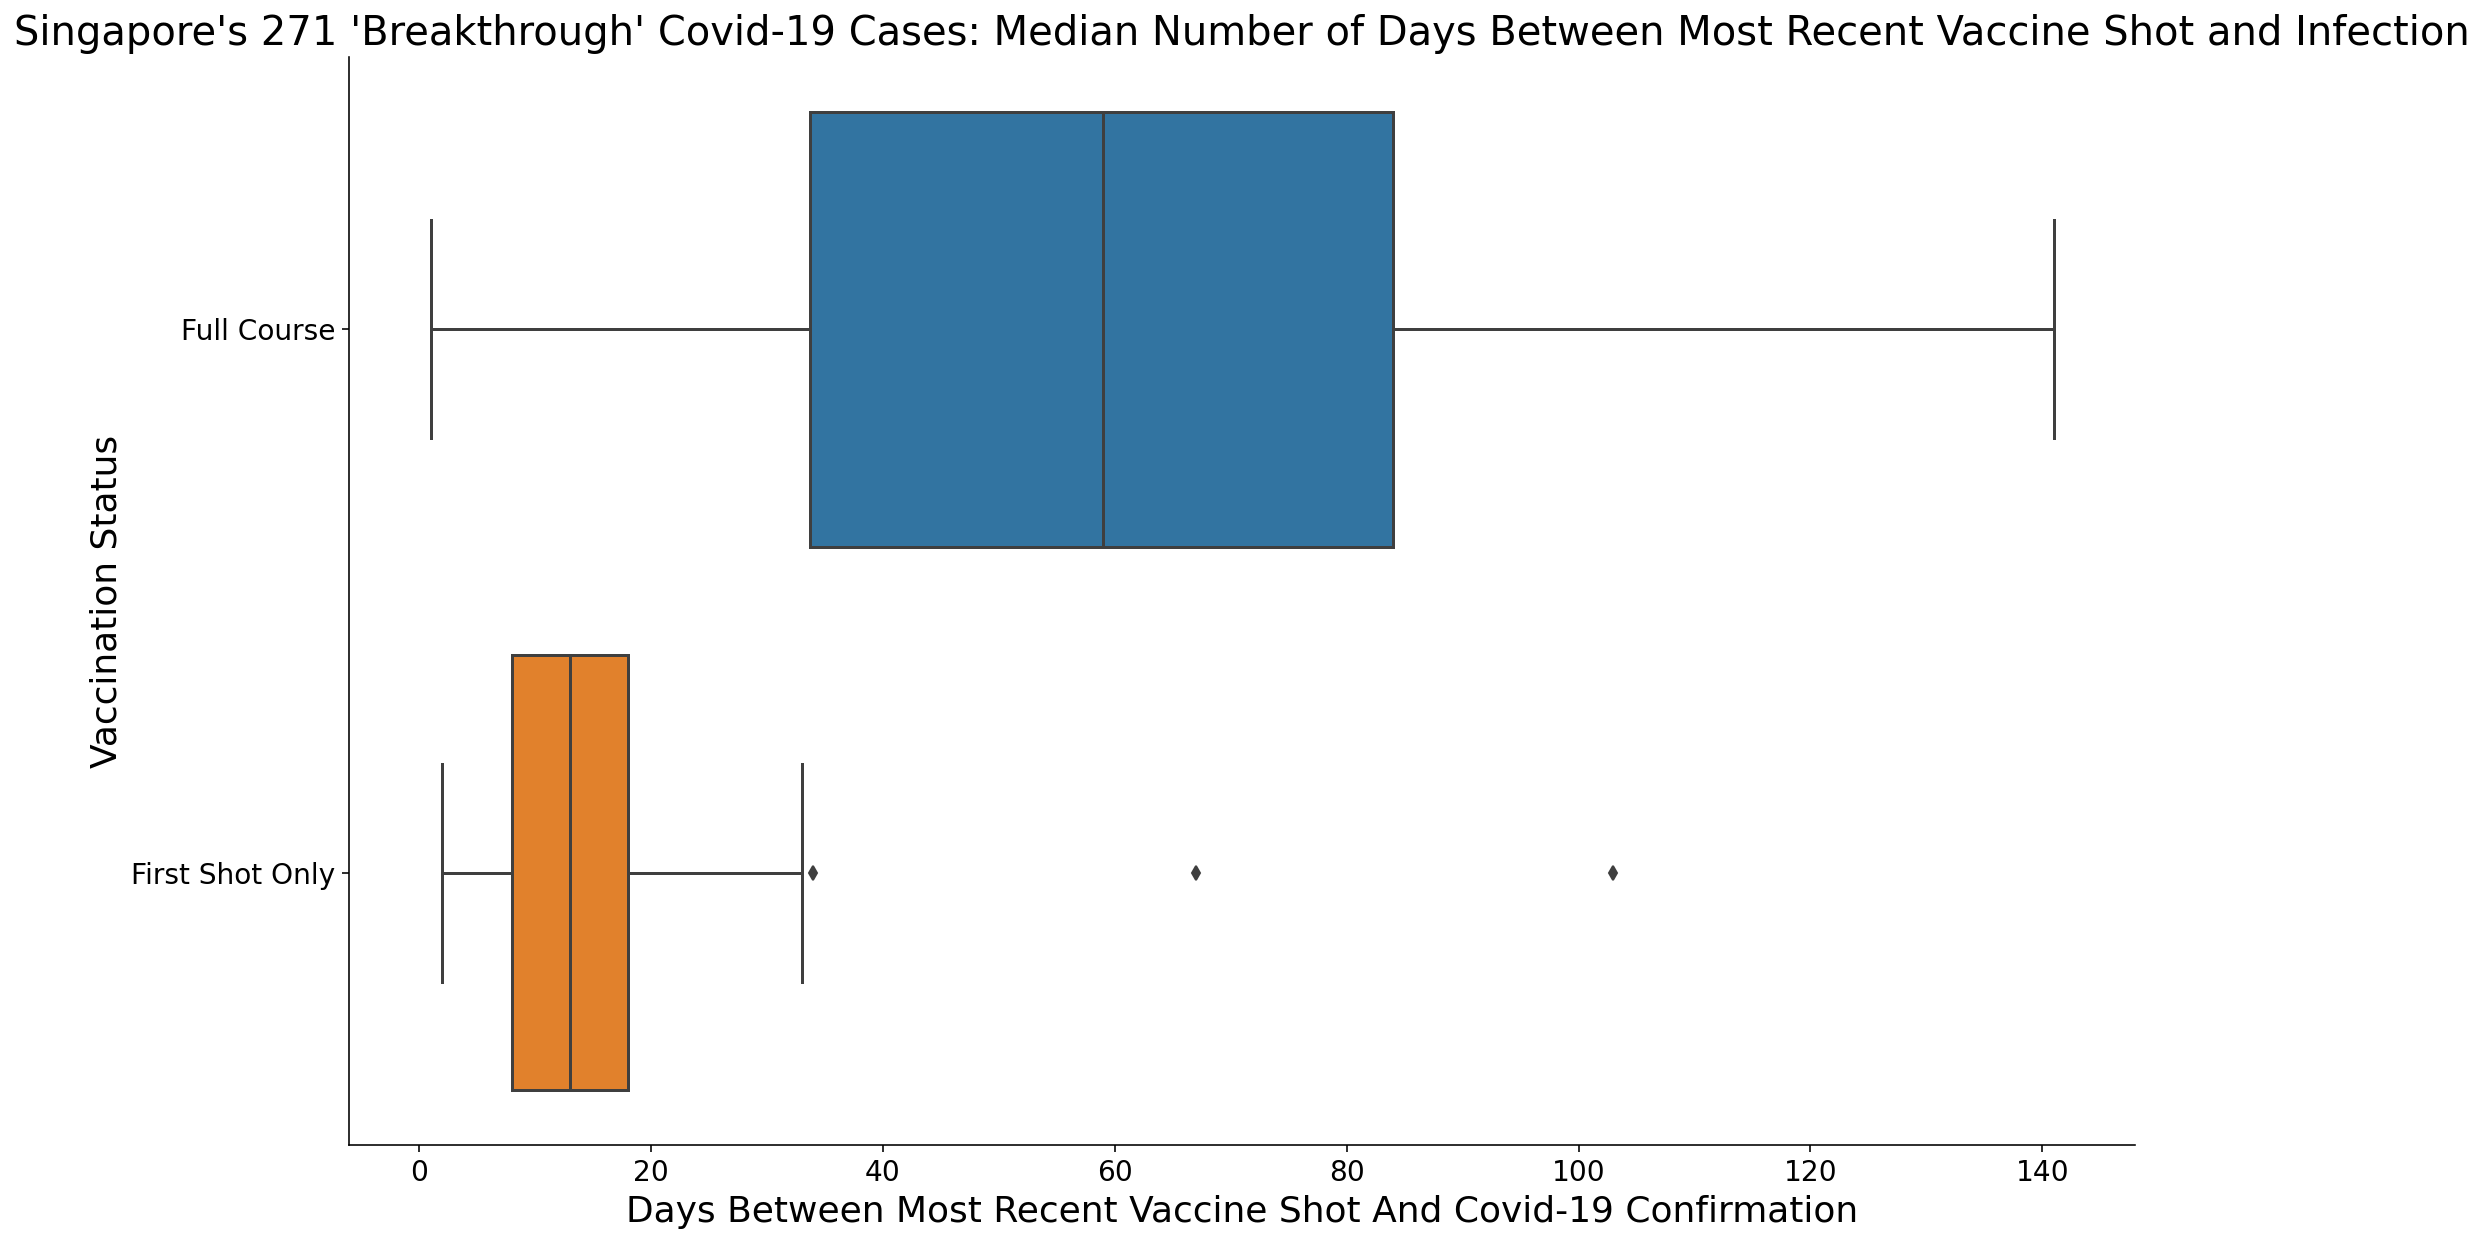

In [44]:
plt.figure(figsize=(16, 10))
sns.boxplot(
    y="Vac_Status",
    x="Days Between Vaccination And Covid-19 Confirmation",
    data=raw,
)
plt.title(
    "Singapore's 271 'Breakthrough' Covid-19 Cases: Median Number of Days Between Most Recent Vaccine Shot and Infection",
    fontsize=20,
)
plt.xlabel("Days Between Most Recent Vaccine Shot And Covid-19 Confirmation", fontsize=18)
plt.ylabel("Vaccination Status", fontsize=18)
plt.grid(False)
sns.despine()
plt.show()

In [45]:
raw.groupby("Vac_Status")["Days Between Vaccination And Covid-19 Confirmation"].median()

Vac_Status
First Shot Only    13
Full Course        59
Name: Days Between Vaccination And Covid-19 Confirmation, dtype: int64